In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import torch
import torch.nn as nn

import utilities
import training_data

IMPORT ERROR: /home/adamrouhiainen/anaconda3/lib/python3.8/site-packages/quicklens/mpi.py. Could not load pbs or pypar. MPI will not be used.
IMPORT ERROR: /home/adamrouhiainen/anaconda3/lib/python3.8/site-packages/quicklens/shts/__init__.py ({}). Try running 'python setup.py install' or 'python setup.py build_ext --inplace' from the quicklens directory.


In [2]:
if torch.cuda.is_available():
  device = 'cuda'
  float_dtype = np.float32
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  torch.cuda.set_device(0)

In [3]:
nx = 64
trainingdata = training_data.TrainingDataPersistentImages_64px_10ave_2p0_Om_s8()

In [4]:
n_hidden_a = 512
n_hidden_b = 1024
n_hidden_c = 256
n_hidden_d = 128

n_hidden_0 = 64
n_hidden_1 = 64
n_hidden_2 = 128
n_hidden_3 = 128
n_hidden_4 = 128

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fca = nn.Linear(    3*2*nx, n_hidden_a)
        self.fcb = nn.Linear(n_hidden_a, n_hidden_b)
        self.fcc = nn.Linear(n_hidden_b, n_hidden_c)
        self.fcd = nn.Linear(n_hidden_c, n_hidden_d)
        self.fce = nn.Linear(n_hidden_d,          2)
        
        self.conv0 = nn.Conv2d(3, n_hidden_0, kernel_size=3)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(n_hidden_0, n_hidden_1, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(n_hidden_1, n_hidden_2, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(n_hidden_2, n_hidden_3, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1   = nn.Linear(n_hidden_3*4, n_hidden_4)
        self.fc2   = nn.Linear(n_hidden_4, 2)

        
    def forward(self, x):
        z = x
        x = torch.concat((torch.sum(x, axis=-2), torch.sum(x, axis=-1)), axis=-1)
        
        x = x.view(-1, 3*2*nx)
        x = torch.relu(self.fca(x))
        x = torch.relu(self.fcb(x))
        x = torch.relu(self.fcc(x))
        x = torch.relu(self.fcd(x))
        x = self.fce(x)
        
        z = torch.relu(self.conv0(z))
        z = self.pool0(z)
        z = torch.relu(self.conv1(z))
        z = self.pool1(z)
        z = torch.relu(self.conv2(z))
        z = self.pool2(z)
        z = torch.relu(self.conv3(z))
        z = self.pool3(z)
        z = z.view(-1, n_hidden_3*4)
        z = torch.relu(self.fc1(z))
        z = self.fc2(z)
        
        return (x + z)/2

In [6]:
net = Net()
params = sum(p.numel() for p in net.parameters())
train_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Parameters:', params, '| Trainable parameters:', train_params)

Parameters: 1344068 | Trainable parameters: 1344068


In [7]:
batch_size = 16
base_lr = 0.0001
optimizer = torch.optim.Adam(net.parameters(), lr=base_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, patience=20)

In [8]:
loss_list = []
val_list  = []

In [9]:
def train_step(net, optimizer, trainingdata):
    net.train()
    optimizer.zero_grad()
    
    #Get data
    x, Om_np, s8_np = trainingdata.draw_samples_of_px(batch_size)
    x = torch.from_numpy(x).float().to(device)
    Om = torch.from_numpy(Om_np).float().to(device)
    s8 = torch.from_numpy(s8_np).float().to(device)
    
    #Run network
    net_out = net(x)
    Om_out, s8_out = net_out[:, 0], net_out[:, 1]
    
    #Loss
    loss = torch.mean((Om_out - Om)**2 + (s8_out - s8)**2)
    loss.backward()
    optimizer.step()
    loss_list.append(utilities.grab(loss))
    return loss

In [10]:
def val_step(net, trainingdata):
    net.eval();
    
    #Get data
    v, Om_np, s8_np = trainingdata.draw_samples_of_pv(batch_size)
    v = torch.from_numpy(v).float().to(device)
    Om = torch.from_numpy(Om_np).float().to(device)
    s8 = torch.from_numpy(s8_np).float().to(device)
    
    #Run network
    net_out = net(v)
    Om_out, s8_out = net_out[:, 0], net_out[:, 1]
    
    #Loss
    val_loss = torch.mean((Om_out - Om)**2 + (s8_out - s8)**2)
    val_list.append(utilities.grab(val_loss))

In [11]:
for era in range(1000):
    for step in range(50):
        loss = train_step(net, optimizer, trainingdata)
        val_step(net, trainingdata)
    scheduler.step(loss)
    print(era, '|', loss_list[-1], '|', val_list[-1], '|', optimizer.param_groups[0]['lr'], end='\x1b[1K\r')

In [12]:
net.eval();

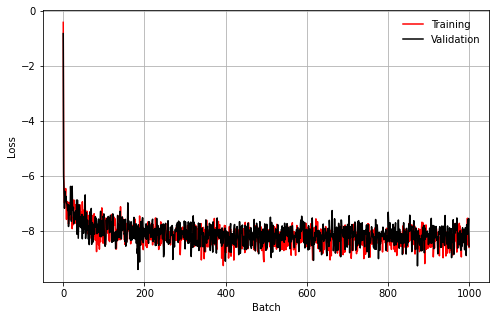

In [13]:
idmin = 0
idmax = len(loss_list)

fig=plt.figure(figsize=(8, 5))
plt.plot(np.log(loss_list[idmin:idmax][::50]), color='red',   label='Training')
plt.plot(np.log( val_list[idmin:idmax][::50]), color='black', label='Validation')
plt.grid()
plt.legend(loc=1, frameon=False)
plt.xlabel('Batch')
plt.ylabel('Loss');

torch.Size([1000, 3, 64, 64])


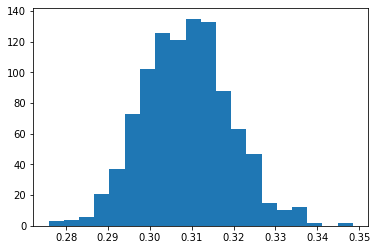

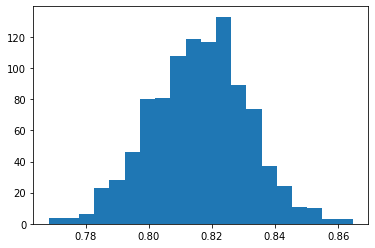

tensor(0.0105, grad_fn=<StdBackward0>)
tensor(0.0154, grad_fn=<StdBackward0>)
tensor([[ 1.1062e-04, -9.7306e-05],
        [-9.7306e-05,  2.3667e-04]], grad_fn=<SqueezeBackward0>)


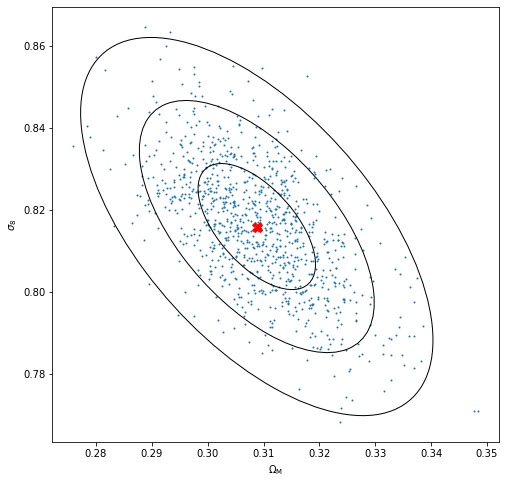

In [19]:
n_test = 1000

with torch.no_grad():
    t, Om_np, s8_np = trainingdata.draw_samples_of_pt(n_test)
    t = torch.from_numpy(t).float().to(device)
    Om = torch.from_numpy(Om_np).float().to(device)
    s8 = torch.from_numpy(s8_np).float().to(device)

net_out = net(t)
print(t.shape)

del t
torch.cuda.empty_cache()

Om_test = net_out[:, 0]
s8_test = net_out[:, 1]

plt.hist(utilities.grab(Om_test), bins=20)
plt.show()
plt.hist(utilities.grab(s8_test), bins=20)
plt.show()

print(Om_test.std())
print(s8_test.std())
print(torch.cov(torch.stack((Om_test, s8_test))))


def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]


x = utilities.grab(Om_test)
y = utilities.grab(s8_test)

nstd = 3
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)

cov = np.cov(x, y)
vals, vecs = eigsorted(cov)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

for stds in range(1, nstd+1):
    w, h = 2 * stds * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)

plt.scatter(x, y, s=1)
#plt.xlim(0.16, 0.46)
#plt.ylim(0.65, 0.95)
plt.xlabel('$\Omega_\mathrm{M}$')
plt.ylabel('$\sigma_8$')
plt.plot(0.3089, 0.8159, marker='X', markersize=10, color='red')
plt.show()

In [21]:
np.save('Om_test_1000_avg', x)
np.save('s8_test_1000_avg', y)

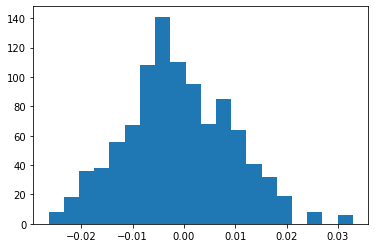

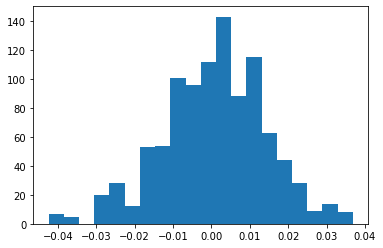

tensor(0.0103, grad_fn=<StdBackward0>)
tensor(0.0137, grad_fn=<StdBackward0>)
tensor([[ 1.0674e-04, -8.4037e-05],
        [-8.4037e-05,  1.8695e-04]], grad_fn=<SqueezeBackward0>)


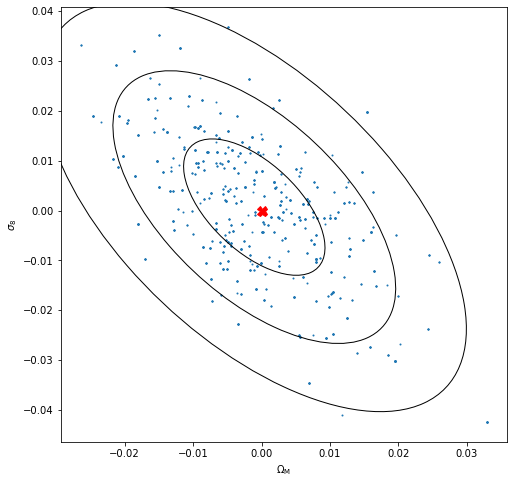

In [15]:
n_test = 1000

with torch.no_grad():
    t, Om_np, s8_np = trainingdata.draw_samples_of_pv(n_test)
    t = torch.from_numpy(t).float().to(device)
    Om = torch.from_numpy(Om_np).float().to(device)
    s8 = torch.from_numpy(s8_np).float().to(device)

net_out = net(t)

del t
torch.cuda.empty_cache()

Om_test = net_out[:, 0]
s8_test = net_out[:, 1]

plt.hist(utilities.grab(Om_test-Om), bins=20)
plt.show()
plt.hist(utilities.grab(s8_test-s8), bins=20)
plt.show()

print((Om_test-Om).std())
print((s8_test-s8).std())
print(torch.cov(torch.stack((Om_test-Om, s8_test-s8))))

x = utilities.grab(Om_test-Om)
y = utilities.grab(s8_test-s8)

nstd = 3
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)

cov = np.cov(x, y)
vals, vecs = eigsorted(cov)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

for stds in range(1, nstd+1):
    w, h = 2 * stds * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)

plt.scatter(x, y, s=1)
#plt.xlim(-0.15, 0.15)
#plt.ylim(-0.15, 0.15)
plt.xlabel('$\Omega_\mathrm{M}$')
plt.ylabel('$\sigma_8$')
plt.plot(0, 0, marker='X', markersize=10, color='red')
plt.show()

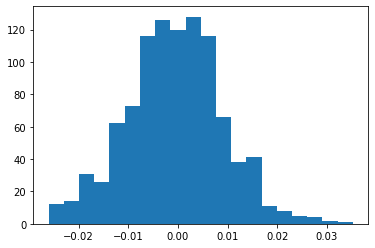

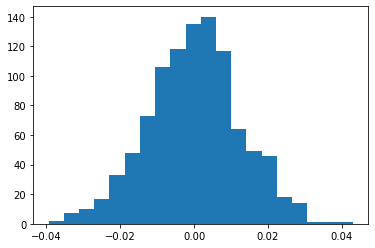

tensor(0.0097, grad_fn=<StdBackward0>)
tensor(0.0125, grad_fn=<StdBackward0>)
tensor([[ 9.4050e-05, -6.9416e-05],
        [-6.9416e-05,  1.5602e-04]], grad_fn=<SqueezeBackward0>)


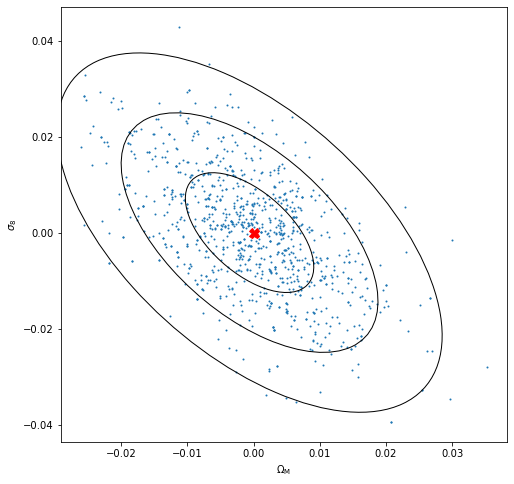

In [16]:
n_test = 1000

with torch.no_grad():
    t, Om_np, s8_np = trainingdata.draw_samples_of_px(n_test)
    t = torch.from_numpy(t).float().to(device)
    Om = torch.from_numpy(Om_np).float().to(device)
    s8 = torch.from_numpy(s8_np).float().to(device)

net_out = net(t)

del t
torch.cuda.empty_cache()

Om_test = net_out[:, 0]
s8_test = net_out[:, 1]

plt.hist(utilities.grab(Om_test-Om), bins=20)
plt.show()
plt.hist(utilities.grab(s8_test-s8), bins=20)
plt.show()

print((Om_test-Om).std())
print((s8_test-s8).std())
print(torch.cov(torch.stack((Om_test-Om, s8_test-s8))))

x = utilities.grab(Om_test-Om)
y = utilities.grab(s8_test-s8)

nstd = 3
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)

cov = np.cov(x, y)
vals, vecs = eigsorted(cov)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

for stds in range(1, nstd+1):
    w, h = 2 * stds * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=w, height=h,
                  angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)

plt.scatter(x, y, s=1)
#plt.xlim(-0.15, 0.15)
#plt.ylim(-0.15, 0.15)
plt.xlabel('$\Omega_\mathrm{M}$')
plt.ylabel('$\sigma_8$')
plt.plot(0, 0, marker='X', markersize=10, color='red')
plt.show()

In [17]:
end

NameError: name 'end' is not defined

In [ ]:
n_test = 10

with torch.no_grad():
    t, Om_np, s8_np = trainingdata.draw_samples_of_pt(n_test)
    t = torch.from_numpy(t).float().to(device)
    Om = torch.from_numpy(Om_np).float().to(device)
    s8 = torch.from_numpy(s8_np).float().to(device)

In [ ]:
net_out = net(t);

In [ ]:
with torch.no_grad():
    for i in range(n_test):
        print('Test sample', i, ':', 'Om net =', np.round(utilities.grab(net_out[i, 0]), 4),
              '  Om true =', np.round(Om_np[i], 4), '  |',
              '  s8 net =', np.round(utilities.grab(net_out[i, 1]), 4),
              '  s8 true =', np.round(s8_np[i], 4))